#### Code to train classification models
**TODO**:
- verif dist fts
- GroupKFold ?
- inspect cat features
- catboost + xgboost + lgbm
- NaNs ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/foursquare/src


## Imports

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [4]:
import os
import gc
import re
import glob
import json
import lofo
import torch
import pickle
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from pandarallel import pandarallel
from inference.main import k_fold_inf
from numerize.numerize import numerize
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from cuml.feature_extraction.text import TfidfVectorizer

pandarallel.initialize(progress_bar=False, use_memory_fs=False)
pd.options.display.max_columns = 500
warnings.simplefilter("ignore")

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
from params import *

from data.features import *
from data.preparation import *
from data.post_processing import *

from utils.logger import prepare_log_folder, create_logger, save_config
from utils.metrics import *

from model_zoo.xgb import objective_xgb, lofo_xgb
from model_zoo.catboost import objective_catboost
from training.main_boosting import k_fold
from utils.plot import *

from matching import get_CV, load_cleaned_data
from pp import get_improved_CV
from dtypes import *

### Params

In [6]:
LEVEL = 1

N_FOLDS = 10  # 10 if LEVEL == 2 else 5

## Model


In [7]:
df = pd.read_csv(DATA_PATH + "train.csv")[["id", "point_of_interest"]]

In [8]:
path = f'../output/folds_{N_FOLDS}.csv'

if os.path.exists(path):
    df_split = pd.read_csv(path)
else:
    from sklearn.model_selection import GroupKFold

    gkf = GroupKFold(n_splits=N_FOLDS)
    splits = list(gkf.split(df["id"], groups=df['point_of_interest']))


    df_split = df[["id", "point_of_interest"]].copy()
    df_split['fold'] = -1

    for i, (_, val_idx) in enumerate(splits):
        df_split.loc[val_idx, 'fold'] = i

    df_split.to_csv(path, index=False)

In [ ]:
if LEVEL == 1:
    df_p = pd.read_csv(OUT_PATH + f"features_train_1.csv", dtype=DTYPES_1)
    THRESHOLD = 0
else:
    THRESHOLD = 0.0075
    df_p = pd.read_csv(OUT_PATH + f"features_train_2_{THRESHOLD}.csv", dtype=DTYPES_2)

In [ ]:
FEATURES = list(df_p.columns[2:])

FEATURES = [
    f for f in FEATURES if f not in ['point_of_interest_1', 'fold_1', 'point_of_interest_2', 'fold_2', 'match']
]

In [ ]:
if "fold_1" not in df_p.columns:
    df_p = df_p.merge(df_split, left_on="id_1", right_on="id", how="left").drop('id', axis=1)
    df_p = df_p.merge(df_split, left_on="id_2", right_on="id", how="left", suffixes=('_1', '_2')).drop('id', axis=1)

In [ ]:
if "match" not in df_p.columns:
    df_p['match'] = (df_p['point_of_interest_1'] == df_p['point_of_interest_2']).astype(int)

In [ ]:
df_p = df_p.sort_values(['id_1', 'id_2']).reset_index(drop=True)

In [ ]:
df_p.head()

### Params

In [ ]:
if LEVEL == 1:
    PARAMS = {
        "xgb":
        {
            "learning_rate": 0.05,
            'max_depth': 10,
            'min_child_weight': 0.01,
            'reg_alpha': 0.01,
            'reg_lambda': 0.1,
            "colsample_bytree": 0.95,
            "subsample": 0.75,
        },    
        "catboost":
        {
            "learning_rate": 0.1,
            'depth': 12,
            "l2_leaf_reg": 0.1,
            "min_data_in_leaf": 2000,
#             "subsample": 0.75,
#             "bootstrap_type": "Poisson",
        },
        "lgbm": {
            "learning_rate": 0.05,
            "num_leaves": 500,
            "reg_alpha": 1,
            "reg_lambda": 10,
            "min_child_samples": 1000,
            "min_split_gain": 0.01,
            "min_child_weight": 0.01,
            "path_smooth": 0.1,
#             "min_data_in_bin": 320,
        }
    }
else:
    PARAMS = {
        "xgb":
        {
            "learning_rate": 0.05,
            'max_depth': 15,
            'colsample_bytree': 0.5,
            'reg_alpha': 1,
            'reg_lambda': 10,
            "min_child_weight": 0.1,
            "gamma": 0.1,
        },
        "catboost":
            {
            'depth': 12,
            "l2_leaf_reg": 0.1,
            "min_data_in_leaf": 2000,
#             'reg_lambda': 0.1,
#             "model_size_reg": 0.5,
#             "border_count": 256,
            },
        "lgbm": {
            "learning_rate": 0.05,
            "num_leaves": 511,
            "colsample_bytree": 0.5,
            "reg_alpha": 1,
            "reg_lambda": 70,
            "min_child_samples": 2000,  # MODIF  # 2000
            "min_split_gain": 0.02,
            "min_child_weight": 0.03,
            "path_smooth": 0.2,
#             "min_data_in_bin": 32,
        }
    }

In [ ]:
OPTIMIZE = False
TRAIN = True
DEBUG = False

### Config

In [ ]:
if LEVEL == 1:
    LOW_IMP = []
else:
    LOW_IMP = [
        'url_cc_max', 'url_cc_min', 'address_any_nan', 'address_both_nan', 'city_any_nan', 'zip_both_nan', 'phone_both_nan'
    ]

In [ ]:
class Config:
    level = LEVEL
    threshold = THRESHOLD

    split = "kf" # if LEVEL == 1 else "kf"
    n_folds = N_FOLDS

    features = FEATURES
    features = [f for f in FEATURES if f not in LOW_IMP]

    cat_features = ['country', 'cat2a', 'cat2b', "langs", "cat_simpl", "name_num", "address_num"]
    cat_features = [c for c in cat_features if c in FEATURES]

    target = "match"
    model = "lgbm"
    params = PARAMS[model]
    selected_folds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    use_es = split == "gkf" 

In [ ]:
if len(Config.cat_features):
    df_p[Config.cat_features] = df_p[Config.cat_features].astype("category")

### Training

In [ ]:
%%time

if TRAIN:
    log_folder = None
    if not DEBUG:
        log_folder = prepare_log_folder(LOG_PATH + f"lvl_{LEVEL}/")
        print(f'Logging results to {log_folder}')
        save_config(Config, log_folder + 'config')
        create_logger(directory=log_folder, name="logs.txt")

    pred_oof, models, ft_imp = k_fold(df_p, Config, log_folder=log_folder)

### Train 2

In [ ]:
class Config:
    level = LEVEL
    threshold = THRESHOLD

    split = "kf" # if LEVEL == 1 else "kf"
    n_folds = N_FOLDS

    features = FEATURES
    features = [f for f in FEATURES if f not in LOW_IMP]

    cat_features = ['country', 'cat2a', 'cat2b', "langs", "cat_simpl", "name_num", "address_num"]
    cat_features = [c for c in cat_features if c in FEATURES]

    target = "match"
    model = "xgb"
    params = PARAMS[model]
    selected_folds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    use_es = split == "gkf" 

In [ ]:
%%time

if TRAIN:
    log_folder = None
    if not DEBUG:
        log_folder = prepare_log_folder(LOG_PATH + f"lvl_{LEVEL}/")
        print(f'Logging results to {log_folder}')
        save_config(Config, log_folder + 'config')
        create_logger(directory=log_folder, name="logs.txt")

    pred_oof, models, ft_imp = k_fold(df_p, Config, log_folder=log_folder)

### Retrieve

In [32]:
if LEVEL == 1:
    EXP_FOLDER = LOG_PATH + "lvl_1/" + "2022-07-02/2/"  # lgb gkf

    EXP_FOLDERS = [
        LOG_PATH + "lvl_1/" + "2022-07-02/2/",  # lgb gkf
        LOG_PATH + "lvl_1/" + "2022-07-02/0/",  # xgb gkf 
#         LOG_PATH + "lvl_1/" + "2022-07-02/4/",  # catboost gkf
    ]
    WEIGHTS = [
        0.75,
        0.25, 
#         0.15
    ]

else:
    EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-27/4/"  # xgboost 5kf
    EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-27/7/"  # lgb 5kf
    
    EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-28/0/"  # lgb 10kf - 0.8982
    
    EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-30/5/"  # lgb gkf - 0.8837
    EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-30/6/"  # xgb gkf - 0.8782
    
#     EXP_FOLDERS = [
#         LOG_PATH + "lvl_2/" + "2022-06-30/2/",
#         LOG_PATH + "lvl_2/" + "2022-06-30/3/",
#     ]

In [33]:
if not TRAIN:
#     pred_oof = np.load(EXP_FOLDER + "pred_oof.npy")
    ft_imp = pd.read_csv(EXP_FOLDER + "ft_imp.csv").set_index('Unnamed: 0')
    
    pred_oof = np.average([np.load(f + "pred_oof.npy") for f in EXP_FOLDERS], weights=WEIGHTS, axis=0)

## Results

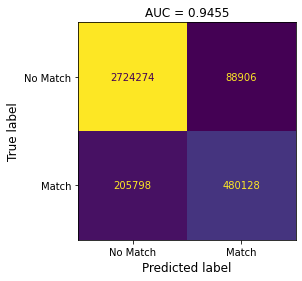

In [34]:
y = df_p[Config.target].values if isinstance(df_p, pd.DataFrame) else df_p[Config.target].get()

plot_confusion_matrix(
    pred_oof > 0.5,
    y,
    display_labels=['No Match', 'Match'],
#     normalize="pred"
)

plt.title(f"AUC = {roc_auc_score(y, pred_oof) :.4f}")
plt.show()

In [35]:
if "m_true" not in df.columns:
    df = df.reset_index()
    df = df.sort_values(by=["point_of_interest", "id"]).reset_index(drop=True)

    id_all = np.array(df["id"])
    poi_all = np.array(df["point_of_interest"])
    poi0 = poi_all[0]
    id0 = id_all[0]

    di_poi = {}
    for i in range(1, df.shape[0]):
        if poi_all[i] == poi0:
            id0 = str(id0) + " " + str(id_all[i])
        else:
            di_poi[poi0] = str(id0) + " "  # need to have trailing space in m_true
            poi0 = poi_all[i]
            id0 = id_all[i]

    di_poi[poi0] = str(id0) + " "  # need to have trailing space in m_true
    df["m_true"] = df["point_of_interest"].map(di_poi)

    df = df.sort_values(by="index").reset_index(
        drop=True
    )  # sort back to original order
    df.drop("index", axis=1, inplace=True)

In [36]:
_ = get_improved_CV(df_p, pred_oof, df.copy())

### Check several cut levels

In [ ]:
if LEVEL == 1:
    df_p[Config.target] = y

    for thresh in [.0025, .005, .0075]:
        print(f'\nRemoving pairs with p < {thresh} : ')
        df_cut = df_p.loc[pred_oof > thresh].reset_index()
        y_cut = df_cut[Config.target].values

        try:
            print(f"- Number of candidates : {numerize(len(y_cut))}")
        except NameError:
            print(f"- Number of candidates : {len(y_cut)}")
        print(f"- Proportion of positive candidates: {y_cut.mean() * 100:.2f}%")

        get_CV(None, None, y_cut, y_cut, df.copy(), df_cut.copy())

In [ ]:
if LEVEL == 1:
    THRESHOLD = 0.0075

    df_p_r = df_p[pred_oof > THRESHOLD].reset_index(drop=True)
    df_p_r.to_csv(OUT_PATH + f"features_train_1_filtered_{THRESHOLD}.csv", index=False)

### Feature importance

In [ ]:
plot_importances(ft_imp)
# plt.xscale('log')
plt.show()